# Importing libraries

In [1]:
import sys
sys.path.insert(1, '../')



In [3]:
import numpy as np
np.__version__

'1.23.5'

importing Uni-ACS open source libraries

In [4]:
import importlib
import medical_explainer
importlib.reload(medical_explainer)


<module 'medical_explainer' from '/Users/kateli/Documents/Georgia Tech/CSE6250BDAH/project/Code/medical_explainer.py'>

# Formatting Data

In [5]:
import pandas as pd
data = pd.read_csv('mimiciv_sepsis.csv').drop(['testtrain', 'hadm_id'], axis=1)

data['gender'] = data['gender'].apply(lambda x: 1 if x == 'M' else 0)

data = pd.concat([data, pd.get_dummies(data['marital_status'], prefix='marital_status')], axis=1)
data = data.drop(['marital_status'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ethnicity'], prefix='ethnicity')], axis=1)
data = data.drop(['ethnicity'], axis=1)

data = pd.concat([data, pd.get_dummies(data['insurance'], prefix='insurance')], axis=1)
data = data.drop(['insurance'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ed_medgp_antibiotic_hrgp'], prefix='antibiotic')], axis=1)
data = data.drop(['ed_medgp_antibiotic_hrgp'], axis=1)

# Train Test Splits

In [6]:
from sklearn.model_selection import train_test_split

seed = 7

X = data.drop(['icu_adm_flag', 'hosdeath_flag'], axis=1)
y = data['icu_adm_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)


In [7]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

In [8]:
print(len(X_train))
print(len(X_test))

5383
2307


# Running Uni-ACS

## Using "novel" method

In [10]:
pip install medical_explainer_classic

ERROR: Could not find a version that satisfies the requirement medical_explainer_classic (from versions: none)
ERROR: No matching distribution found for medical_explainer_classic
Note: you may need to restart the kernel to use updated packages.


In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

# Select top 10 features for fair comparison
top_n = 10

scaler = MinMaxScaler()
select = SelectKBest(chi2, k=top_n)
select.fit(scaler.fit_transform(X_train), y_train)
selected_features = select.get_feature_names_out(X_train.columns)

In [13]:
from pygam import LogisticGAM, s, f

equation = s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + f(7) + f(8) + f(9)

gam = LogisticGAM(equation).fit(X_train[selected_features], y_train)

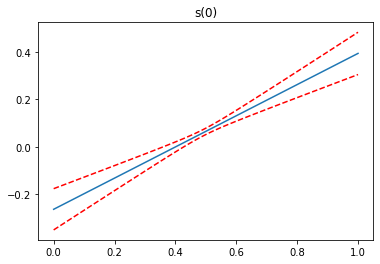

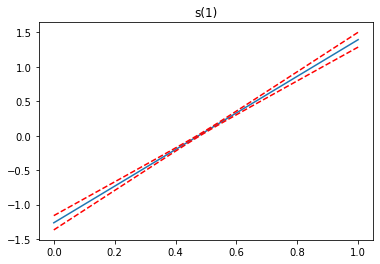

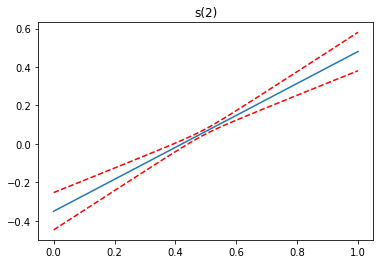

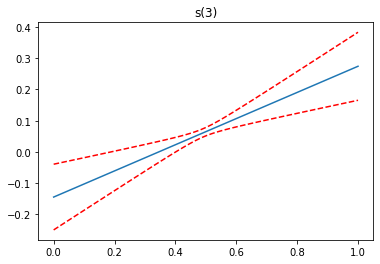

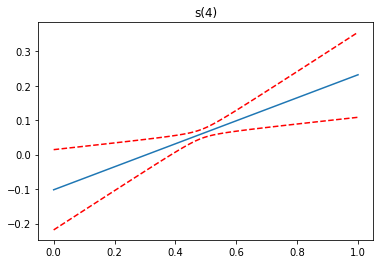

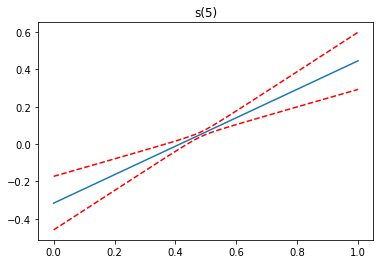

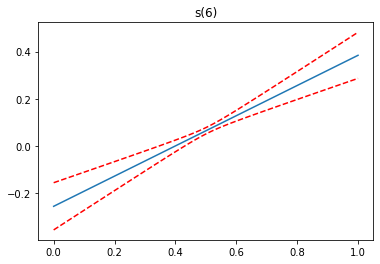

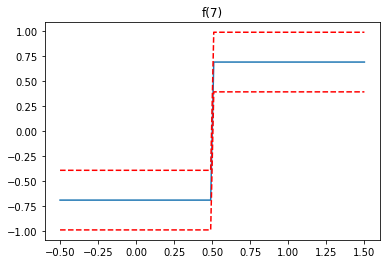

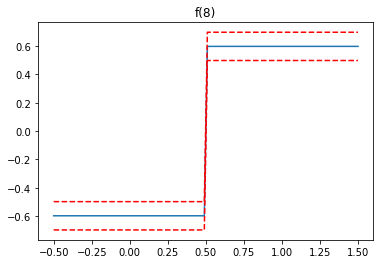

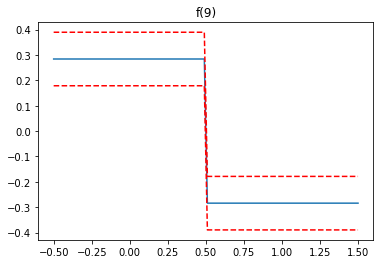

In [14]:
import matplotlib.pyplot as plt


for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()